<a href="https://colab.research.google.com/github/ngocngoc0406/NCKH/blob/main/graph_job_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00
✅ All dependencies installed. PLEASE RESTART RUNTIME.
HAS_FITZ: True
HAS_PDFPLUMBER: True
HAS_OCR: True


Saving db_job_tuan.xlsx to db_job_tuan.xlsx
 Loaded JOB file: db_job_tuan.xlsx | shape: (500, 14)
 Clean df: (500, 12)


Saving CV - Nguyễn Thị Ngọc _ Intern Tester.pdf to CV - Nguyễn Thị Ngọc _ Intern Tester.pdf
 Loaded CV: CV - Nguyễn Thị Ngọc _ Intern Tester.pdf
=== CV TEXT PREVIEW ===
NGUYỄN THỊ NGỌC
Intern Tester (QA / Manual)
📞 0368 505 043
✉ ngocngoc2pl@gmail.com
📍 Đà Nẵng
GitHub: ngocngoc0406
LinkedIn: Profile
PROFILE SUMMARY
Final-year Software Engineering student at VKU seeking an Intern Tester position. Familiar with
manual testing process including test case design, functional testing and bug reporting.
Careful, detail-oriented and eager to learn QA workflows in professional software
development environments.
PROJECT EXPERIENCE
WebBanHang – E-commerce Website
Role: Manual Tester
Analyzed functional requirements and user flows.
Designed detailed test cases for login, cart and checkout modules.
Executed manual testing and compared actual vs expected results.
Reported bugs with clear steps to reproduce.
Re-tested features after fixes.
QuanLyLaptop – Management System
Role: Tester
Tested CRUD fun

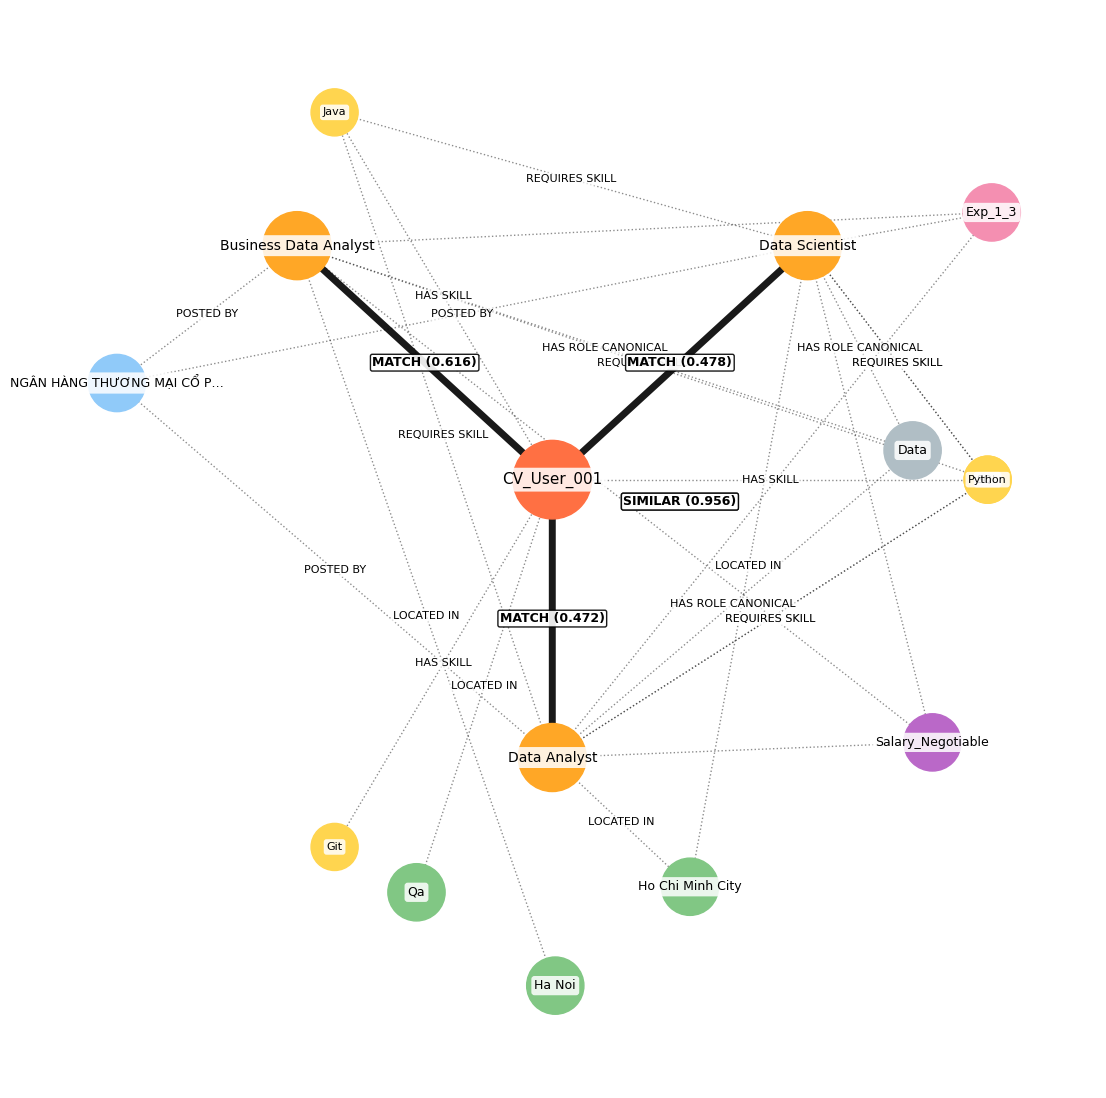


================= XAI FIDELITY TEST =================
Job: Business Data Analyst
  Original score: 0.616
  Remove skill 'SQL' → new score: 0.616
  Score drop: 0.0

Job: Data Scientist
  Original score: 0.478
  Remove skill 'Java' → new score: 0.478
  Score drop: 0.0

Job: Data Analyst
  Original score: 0.472
  Remove skill 'Java' → new score: 0.472
  Score drop: 0.0


================= EVALUATION =================

Evaluation (mean ± std) over 5 trials, sample size 100 each

Method: ours
  Recall@1: 0.054 ± 0.026
  Recall@3: 0.112 ± 0.028
  Recall@5: 0.156 ± 0.033
  Recall@10: 0.256 ± 0.030
  MRR: 0.119 ± 0.024
  NDCG@10: 0.136 ± 0.026

Method: text_only
  Recall@1: 1.000 ± 0.000
  Recall@3: 1.000 ± 0.000
  Recall@5: 1.000 ± 0.000
  Recall@10: 1.000 ± 0.000
  MRR: 1.000 ± 0.000
  NDCG@10: 1.000 ± 0.000

Method: skill_only
  Recall@1: 0.032 ± 0.018
  Recall@3: 0.080 ± 0.014
  Recall@5: 0.108 ± 0.016
  Recall@10: 0.174 ± 0.043
  MRR: 0.085 ± 0.015
  NDCG@10: 0.093 ± 0.020

Robustness (n

In [ ]:
# =========================================================
# 0) INSTALL ALL DEPENDENCIES
# =========================================================


!pip -q install --upgrade pip

!pip -q install \
    numpy \
    pandas \
    scikit-learn \
    networkx \
    matplotlib \
    rdflib \
    openpyxl \
    pillow \
    pymupdf \
    pdfplumber \
    pytesseract

print("✅ All dependencies installed. PLEASE RESTART RUNTIME.")
# =========================================================
# 1) IMPORTS + ENV (DEFENSIVE)
# =========================================================
import os, re, glob, unicodedata, math, random
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# ---------- PDF TEXT ----------
try:
    import fitz  # PyMuPDF
    HAS_FITZ = True
except Exception:
    HAS_FITZ = False

try:
    import pdfplumber
    HAS_PDFPLUMBER = True
except Exception:
    HAS_PDFPLUMBER = False

try:
    import pytesseract
    HAS_OCR = True
except Exception:
    HAS_OCR = False

from PIL import Image

# ---------- RDF ----------
from rdflib import Graph as RDFGraph, Namespace, RDF, RDFS, OWL, Literal
from rdflib.namespace import XSD

plt.rcParams["figure.figsize"] = (14, 14)

# ---------- Detect Colab ----------
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

print("HAS_FITZ:", HAS_FITZ)
print("HAS_PDFPLUMBER:", HAS_PDFPLUMBER)
print("HAS_OCR:", HAS_OCR)

# =========================================================
# 2) SETTINGS (CHỈNH Ở ĐÂY)
# =========================================================
# --- User–Job (chính) ---
TOPK_USER_JOB      = 3
W_SKILL            = 0.78
W_LOC              = 0.22

# --- Job–Job (AUXILIARY ONLY – NOT CORE CONTRIBUTION) ---
SIM_THRESHOLD      = 0.45
TOPK_SIMILAR       = 2        # GIẢM prominence
CANDIDATES_TOP     = 15


# --- Draw ---
FOCUS_ONLY         = True
MAX_SKILLS_DRAW    = 10
EDGE_LABEL_MODE    = "important"   # "all" | "important"
SHOW_EDGE_SCORES   = True
CENTER_MODE        = "user"        # "user" | "top_job" | "job_id" | "random_job"
CENTER_JOB_ID      = None
RANDOM_SEED        = 42

# --- CV PDF OCR fallback ---
OCR_LANG           = "vie+eng"     # nếu máy không có vie, tự fallback eng
OCR_DPI            = 200
OCR_MAX_PAGES      = 3             # OCR vài trang đầu (CV thường 1-2 trang)

# --- Prob skill ---
MIN_KEEP_PROB      = 0.08

# =========================================================
# 3) TEXT HELPERS
# =========================================================
def norm_text(t):
    if t is None:
        return ""
    s = unicodedata.normalize("NFKD", str(t).lower())
    s = "".join(c for c in s if not unicodedata.combining(c))
    s = re.sub(r"\s+", " ", s).strip()
    return s

def safe_id(t):
    s = norm_text(t)
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s if s else "unknown"

def short_label(text, maxlen=30):
    s = re.sub(r"\s+", " ", str(text)).strip()
    return s if len(s) <= maxlen else s[:maxlen-1] + "…"

# =========================================================
# A) STABLE ID (thay safe_id cho KG)
# =========================================================
import hashlib

def sid(prefix: str, raw: str, n=8):
    raw = "" if raw is None else str(raw)
    base = norm_text(raw)
    h = hashlib.md5(base.encode("utf-8")).hexdigest()[:n]
    slug = re.sub(r"[^a-z0-9]+", "_", base).strip("_")
    return f"{prefix}_{slug}_{h}"


# =========================================================
# 4) LOAD JOB EXCEL (upload / auto-find)
# =========================================================
def load_excel():
    if IN_COLAB:
        from google.colab import files  # type: ignore
        uploaded = files.upload()
        path = list(uploaded.keys())[0]
    else:
        cand = []
        cand += glob.glob("*.xlsx")
        cand += glob.glob("/mnt/data/*.xlsx")
        cand += glob.glob("/kaggle/working/*.xlsx")
        if not cand:
            raise FileNotFoundError("❌ Không thấy file .xlsx (job). Đặt file vào working dir hoặc upload (Colab).")
        path = cand[0]

    df_raw = pd.read_excel(path, engine='openpyxl').fillna("")
    df_raw.columns = [str(c).strip() for c in df_raw.columns]
    return path, df_raw

job_file, df_raw = load_excel()
print(" Loaded JOB file:", job_file, "| shape:", df_raw.shape)

# column mapping theo file bạn
COL = {
    "job_id": "JobID",
    "job_url": "URL_Job",
    "job_title": "Title",
    "company": "Name company",
    "location": "Job Address",
    "location_detail": "Job Address detail",
    "requirements": "Job Requirements",
    "salary": "Salary",
    "experience": "Experience",
    "job_desc": "Job description",
    "job_type": "Job type",
    "benefit": "benefit"
}
missing = [v for v in COL.values() if v not in df_raw.columns]
if missing:
    raise ValueError(f" Thiếu cột trong file job: {missing}")

df = pd.DataFrame({
    "job_id": df_raw[COL["job_id"]].astype(str),
    "job_url": df_raw[COL["job_url"]].astype(str),
    "job_title": df_raw[COL["job_title"]].astype(str),
    "company": df_raw[COL["company"]].astype(str),
    "location": df_raw[COL["location"]].astype(str),
    "location_detail": df_raw[COL["location_detail"]].astype(str),
    "requirements": df_raw[COL["requirements"]].astype(str),
    "salary": df_raw[COL["salary"]].astype(str),
    "experience": df_raw[COL["experience"]].astype(str),
    "job_desc": df_raw[COL["job_desc"]].astype(str),
    "job_type": df_raw[COL["job_type"]].astype(str),
    "benefit": df_raw[COL["benefit"]].astype(str),
}).reset_index(drop=True)

print(" Clean df:", df.shape)

# =========================================================
# 5) LOAD CV PDF (text + OCR fallback)
# =========================================================
def upload_or_find_pdf():
    if IN_COLAB:
        from google.colab import files  # type: ignore
        uploaded = files.upload()
        path = list(uploaded.keys())[0]
        return path
    cand = []
    cand += glob.glob("*.pdf")
    cand += glob.glob("/mnt/data/*.pdf")
    cand += glob.glob("/kaggle/working/*.pdf")
    if not cand:
        raise FileNotFoundError(" Không thấy CV .pdf. Đặt file .pdf vào working dir hoặc upload (Colab).")
    return cand[0]

def extract_text_pymupdf(pdf_path):
    if not HAS_FITZ:
        return ""
    doc = fitz.open(pdf_path)
    texts = [p.get_text("text") for p in doc]
    return "\n".join(texts).strip()


def ocr_pdf_first_pages(pdf_path, max_pages=3, dpi=200, lang="vie+eng"):
    out = []
    try:
        with pdfplumber.open(pdf_path) as pdf:
            pages = pdf.pages[:max_pages]
            for i, page in enumerate(pages):
                img = page.to_image(resolution=dpi).original
                pil = img.convert("RGB")
                try:
                    t = pytesseract.image_to_string(pil, lang=lang)
                except Exception:
                    # fallback eng
                    t = pytesseract.image_to_string(pil, lang="eng")
                out.append(t)
    except Exception as e:
        print(" OCR error:", e)
    return "\n".join(out).strip()

cv_pdf = upload_or_find_pdf()
cv_text = extract_text_pymupdf(cv_pdf)

# nếu text quá ít -> OCR
if len(cv_text) < 200:
    print(" PDF text quá ít -> chạy OCR fallback…")
    cv_text_ocr = ocr_pdf_first_pages(cv_pdf, max_pages=OCR_MAX_PAGES, dpi=OCR_DPI, lang=OCR_LANG)
    if len(cv_text_ocr) > len(cv_text):
        cv_text = cv_text_ocr

CV_TEXT = cv_text
print(" Loaded CV:", cv_pdf)
print("=== CV TEXT PREVIEW ===")
print(CV_TEXT[:1500])

# =========================================================
# 6) LOCATION: city + detail + match score
# =========================================================
VN_CITY_ALIASES = {
    "tp hcm": "Ho Chi Minh City",
    "tphcm": "Ho Chi Minh City",
    "hcm": "Ho Chi Minh City",
    "sai gon": "Ho Chi Minh City",
    "ho chi minh": "Ho Chi Minh City",
    "ha noi": "Ha Noi",
    "hanoi": "Ha Noi",
    "da nang": "Da Nang",
    "danang": "Da Nang",
    "can tho": "Can Tho",
    "hai phong": "Hai Phong",
    "binh duong": "Binh Duong",
    "dong nai": "Dong Nai",
}
DETAIL_CUES = ["quan","q","huyen","phuong","duong","street","ward","district","tp","thi xa","thi tran"]

def parse_location_city_detail(text: str):
    s0 = str(text or "").strip()
    if not s0:
        return "Unknown", ""
    s = norm_text(s0).replace(".", " ").replace("-", " ")
    s = re.sub(r"\s+", " ", s).strip()
    parts = [p.strip() for p in re.split(r"[,;/|]+", s) if p.strip()]
    if not parts:
        parts = [s]

    city = None
    for k, v in VN_CITY_ALIASES.items():
        if re.search(rf"(?<!\w){re.escape(k)}(?!\w)", s):
            city = v
            break

    if city is None:
        tail = parts[-1]
        city = VN_CITY_ALIASES.get(tail, str(tail).title())
        parts = parts[:-1]

    detail_parts = []
    for p in parts:
        if any(cue in p for cue in DETAIL_CUES) or len(p) >= 6:
            detail_parts.append(p)
    detail = " ".join(detail_parts).strip()
    return city, detail

def location_match_score(user_city, user_detail, job_city, job_detail):
    if user_city == "Unknown" or job_city == "Unknown":
        return 0.0, {"city_match": 0, "detail_match": 0}
    if norm_text(user_city) != norm_text(job_city):
        return 0.0, {"city_match": 0, "detail_match": 0}

    ud = set(norm_text(user_detail).split()) if user_detail else set()
    jd = set(norm_text(job_detail).split()) if job_detail else set()
    if not ud or not jd:
        return 0.8, {"city_match": 1, "detail_match": 0}

    inter = len(ud & jd)
    union = len(ud | jd)
    jacc = inter / union if union else 0.0
    score = 0.8 + 0.2*jacc
    return float(round(score, 3)), {"city_match": 1, "detail_match": round(jacc,3)}

# =========================================================
# 7) ROLE (soft ontology) + exp/salary buckets
# =========================================================
ROLE_PATTERNS = [
    (r"\bke toan thue\b|\btax accountant\b", "Tax Accountant"),
    (r"\bke toan tong hop\b|\bgeneral accountant\b", "General Accountant"),
    (r"\bke toan noi bo\b|\binternal accountant\b", "Internal Accountant"),
    (r"\bke toan\b|\baccountant\b", "Accountant"),
    (r"\bkiem toan\b|\baudit\b", "Auditor"),
    (r"\bfinance\b|\bfinancial\b", "Finance"),
    (r"\bhr\b|\bnhan su\b", "HR"),
    (r"\bsales\b|\bkinh doanh\b", "Sales"),
    (r"\bdata\b", "Data"),
    (r"\bdeveloper\b|\bengineer\b|\bsoftware\b", "Software Engineer"),
]
def infer_role_canonical(title: str) -> str:
    t = norm_text(title)
    for pat, role in ROLE_PATTERNS:
        if re.search(pat, t):
            return role
    return "Other"
def infer_role_raw(title: str) -> str:
    return str(title).strip() if title else "Unknown"

ROLE_SIM = {
    ("Tax Accountant", "General Accountant"): 0.70,
    ("Internal Accountant", "General Accountant"): 0.60,
    ("Accountant", "General Accountant"): 0.55,
    ("Accountant", "Tax Accountant"): 0.45,
}
def role_sim(r1, r2):
    if r1 == r2:
        return 1.0
    return ROLE_SIM.get((r1, r2), ROLE_SIM.get((r2, r1), 0.0))

def parse_year_range(text):
    t = norm_text(text)
    if not t or t in ["unknown", "nan"]:
        return None, None, "Unknown"

    # FIX: dưới 1 năm / <1 year
    if re.search(r"duoi\s*1|<\s*1|less\s*than\s*1", t):
        return 0, 1, "Range"

    # fresher / intern
    if any(k in t for k in ["fresher", "intern", "moi ra truong", "0 nam"]):
        return 0, 0, "Fixed"

    nums = [int(x) for x in re.findall(r"\d+", t)]
    if len(nums) >= 2:
        a, b = nums[0], nums[1]
        if a > b: a, b = b, a
        return a, b, "Range"

    if len(nums) == 1:
        return nums[0], nums[0], "Fixed"

    return None, None, "Unknown"


def exp_bucket(miny, maxy):
    if miny is None:
        return "Exp_Unknown"
    if maxy <= 1: return "Exp_0_1"
    if maxy <= 3: return "Exp_1_3"
    if maxy <= 5: return "Exp_3_5"
    return "Exp_5_plus"

EXP_NEAR = {
    ("Exp_0_1","Exp_1_3"): 0.6,
    ("Exp_1_3","Exp_3_5"): 0.6,
    ("Exp_3_5","Exp_5_plus"): 0.5,
}
def exp_sim(e1, e2):
    if e1 == "Exp_Unknown" or e2 == "Exp_Unknown":
        return 0.0
    if e1 == e2:
        return 1.0
    return EXP_NEAR.get((e1, e2), EXP_NEAR.get((e2, e1), 0.0))

def parse_salary_vnd(text):
    t = norm_text(text)
    if not t or t in ["unknown", "nan"]:
        return None, None, "Unknown"
    if any(k in t for k in ["thoả thuận", "thỏa thuận", "thoa thuan", "negotiable"]):
        return None, None, "Negotiable"
    nums = [int(x) for x in re.findall(r"\d+", t)]
    if not nums:
        return None, None, "Unknown"
    if len(nums) >= 2:
        lo, hi = nums[0], nums[1]
        if lo > hi: lo, hi = hi, lo
        if hi < 1000:
            return lo*1_000_000, hi*1_000_000, "Range"
        return lo, hi, "Range"
    v = nums[0]
    if v < 1000:
        v *= 1_000_000
    return v, v, "Fixed"

def salary_bucket(mins, maxs, sal_type):
    if sal_type == "Negotiable":
        return "Salary_Negotiable"
    if mins is None:
        return "Salary_Unknown"
    if maxs <= 10_000_000: return "Salary_0_10M"
    if maxs <= 20_000_000: return "Salary_10_20M"
    if maxs <= 40_000_000: return "Salary_20_40M"
    return "Salary_40M_plus"
# =========================================================
# SALARY PARSE (USD / VND + negotiable) — FIXED
# =========================================================

def parse_salary(text):
    t = norm_text(text)
    if not t:
        return None, None, "UNK", False

    if any(k in t for k in ["thoả thuận","thỏa thuận","thoa thuan","negotiable"]):
        return None, None, "UNK", True

    cur = "USD" if ("$" in t or "usd" in t) else "VND"
    nums = re.findall(r"\d+(?:[.,]\d+)*", t)
    if not nums:
        return None, None, cur, False

    def to_num(x):
        x = x.replace(",", "")
        v = float(x)
        if cur == "VND" and v < 1000:
            v *= 1_000_000
        return int(v)

    vals = [to_num(x) for x in nums[:2]]
    if len(vals) == 1:
        return vals[0], vals[0], cur, False

    lo, hi = sorted(vals)
    return lo, hi, cur, False


def salary_bucket_general(lo, hi, cur, nego):
    if nego:
        return "Salary_Negotiable"
    if lo is None:
        return "Salary_Unknown"

    if cur == "USD":
        if hi <= 1000: return "Salary_USD_<1k"
        if hi <= 3000: return "Salary_USD_1k_3k"
        return "Salary_USD_3k_plus"

    if hi <= 10_000_000: return "Salary_0_10M"
    if hi <= 20_000_000: return "Salary_10_20M"
    if hi <= 40_000_000: return "Salary_20_40M"
    return "Salary_40M_plus"



# =========================================================
# 8) PROBABILISTIC SKILL (raw->canonical, alias)
# =========================================================
SKILL_LEXICON = {
    "Python":        ["python", "py", "python3", "python 3"],
    "Java":          ["java"],
    "JavaScript":    ["javascript", "js", "ecmascript"],
    "TypeScript":    ["typescript", "ts"],
    "React":         ["react", "reactjs", "react.js"],
    "NodeJS":        ["nodejs", "node.js", "node"],
    "SQL":           ["sql", "mysql", "postgresql", "postgres", "mssql", "sql server"],
    "Docker":        ["docker"],
    "Kubernetes":    ["kubernetes", "k8s"],
    "AWS":           ["aws", "amazon web services"],
    "Git":           ["git", "github"],
    "Excel":         ["excel", "pivot", "vlookup", "power query"],
    "SAP":           ["sap"],
    "MISA":          ["misa"],
    "QuickBooks":    ["quickbooks"],
    "VAT":           ["vat", "gtgt"],
    "Invoice":       ["hoa don", "invoice", "e-invoice", "einvoice", "e invoice"],
    "Tax":           ["thue", "tax"],
    "Audit":         ["kiem toan", "audit"],
    "AR/AP":         ["cong no", "ar", "ap", "accounts payable", "accounts receivable"],
    "Bookkeeping":   ["so sach", "bookkeeping"],
    "Financial Reporting": ["bao cao tai chinh", "financial reporting", "financial statement", "financial statements"],
    "Tax Finalization": ["quyet toan", "tax finalization"],
}
CORE_SKILLS_CANON = {"Excel","Tax","VAT","Invoice","Financial Reporting","Audit","SAP","MISA","AR/AP","Bookkeeping"}

def _compile_skill_patterns(lexicon: dict):
    comp = {}
    for canon, aliases in lexicon.items():
        pats = []
        for a in aliases:
            a_norm = norm_text(a)
            if " " in a_norm or "-" in a_norm:
                pats.append(rf"(?<!\w){re.escape(a_norm)}(?!\w)")
            else:
                pats.append(rf"\b{re.escape(a_norm)}\b")
        comp[canon] = re.compile("|".join(pats), flags=re.IGNORECASE)
    return comp

SKILL_PATTERNS = _compile_skill_patterns(SKILL_LEXICON)

from sklearn.feature_extraction.text import TfidfVectorizer

# build skill-level TF-IDF (char-wb) to support meaningful p(r->c)
_skill_texts = []
_skill_to_canon = []
for canon, aliases in SKILL_LEXICON.items():
    _skill_texts.append(norm_text(canon))
    _skill_to_canon.append(canon)
    for a in aliases:
        _skill_texts.append(norm_text(a))
        _skill_to_canon.append(canon)

_skill_tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), min_df=1)
_skill_X = _skill_tfidf.fit_transform(_skill_texts)

from sklearn.metrics.pairwise import cosine_similarity

def best_canonical_match(phrase: str):
    """Return best canonical skill and a similarity score in [0,1] using char-wb TF-IDF cosine against canon+aliases."""
    p = norm_text(phrase)
    if not p:
        return None, 0.0
    vp = _skill_tfidf.transform([p])
    sims = cosine_similarity(vp, _skill_X).ravel()
    if sims.size == 0:
        return None, 0.0
    best_idx = int(sims.argmax())
    best_score = float(sims[best_idx])
    best_canon = _skill_to_canon[best_idx]
    return best_canon, best_score

SECTION_HINTS = {
    "skills":     ["ky nang", "kỹ năng", "skills", "technical skills", "skill set", "core skills"],
    "experience": ["kinh nghiem", "kinh nghiệm", "experience", "work history", "employment"],
    "projects":   ["du an", "dự án", "projects", "project"],
    "education":  ["hoc van", "học vấn", "education"],
    "summary":    ["tom tat", "tóm tắt", "summary", "profile", "about"],
    "certs":      ["chung chi", "chứng chỉ", "certifications", "certificate"],
}
SECTION_WEIGHT = {
    "skills": 0.70,
    "experience": 0.45,
    "projects": 0.35,
    "certs": 0.40,
    "summary": 0.30,
    "education": 0.15,
    "unknown": 0.25,
}

def split_cv_sections(cv_text: str):
    raw = str(cv_text or "")
    lines = [l.strip() for l in raw.splitlines()]
    sections = defaultdict(list)
    cur = "unknown"

    def is_heading(line_norm: str):
        for sec, keys in SECTION_HINTS.items():
            for k in keys:
                kn = norm_text(k)
                if line_norm == kn or line_norm.startswith(kn + ":"):
                    return sec
        return None

    for line in lines:
        if not line:
            continue
        ln = norm_text(line)
        sec = is_heading(ln)
        if sec:
            cur = sec
            continue
        sections[cur].append(line)

    out = {k: "\n".join(v) for k, v in sections.items() if v}
    if not out:
        out = {"unknown": raw}
    return out

def _combine_probs(ps):
    out = 0.0
    for p in ps:
        out = 1 - (1 - out) * (1 - float(p))
    return float(min(0.999, max(0.0, out)))

def extract_skills_probabilistic(text: str, min_keep=MIN_KEEP_PROB):
    sections = split_cv_sections(text)
    skills_prob = {}
    raw_hits = defaultdict(list)

    for sec, chunk in sections.items():
        w_sec = SECTION_WEIGHT.get(sec, 0.25)
        chunk_norm = norm_text(chunk)

        for canon, pat in SKILL_PATTERNS.items():
            matches = list(pat.finditer(chunk_norm))
            if not matches:
                continue

            m = min(len(matches), 4)
            p_occ = 1 - (1 - w_sec) ** m
            if canon in CORE_SKILLS_CANON:
                p_occ = min(0.95, p_occ + 0.05)

            prev = skills_prob.get(canon, 0.0)
            skills_prob[canon] = _combine_probs([prev, p_occ])

            for mt in matches[:3]:
                span = chunk_norm[max(0, mt.start()-18): mt.end()+18]
                raw_hits[canon].append(("alias_hit", sec, span))

    skills_prob = {k: round(v, 3) for k, v in skills_prob.items() if v >= min_keep}
    return skills_prob, dict(raw_hits)

def weighted_skill_overlap_prob(user_prob: dict, job_prob: dict):
    """
    Job-centric coverage: user đáp ứng require của job bao nhiêu
    """
    if not job_prob:
        return 0.0, {"reason": "no_job_skill_signal", "top_skill_contrib": []}

    num = 0.0
    den = 0.0
    contrib = []

    for s, pj in job_prob.items():
        w = 2.0 if s in CORE_SKILLS_CANON else 1.0
        pu = float(user_prob.get(s, 0.0))
        num += min(pu, pj) * w
        den += pj * w
        if pu > 0:
            contrib.append((s, round(min(pu, pj) * w, 4), round(pu,3), round(pj,3), w))

    score = (num / den) if den > 0 else 0.0
    contrib.sort(key=lambda x: x[1], reverse=True)
    return float(round(score, 3)), {"top_skill_contrib": contrib[:10]}
# =========================================================
# SkillRaw + uncertainty-aware linking (SINGLE CANONICAL VERSION)
# raw2can_map  : raw_phrase -> [(canon, p)]
# raw2can_best : canon -> (best_raw_phrase, best_p)
# =========================================================

def add_skillraw_nodes_and_links(G, owner_n, text, owner_rel_raw, fuzzy_threshold=0.78):
    text_n = norm_text(text)
    raw2can_map = defaultdict(list)
    seen_raws = set()

    # 1) exact / alias matches
    for canon, pat in SKILL_PATTERNS.items():
        for m in pat.finditer(text_n):
            phrase = m.group(0)
            if phrase in seen_raws:
                continue

            raw_n = f"skillraw::{sid('raw', phrase)}"
            can_n = f"skill::{sid('skill', canon)}"

            add_node(raw_n, "SkillRaw", phrase)
            add_node(can_n, "Skill", canon)

            p = 0.70 if norm_text(phrase) == norm_text(canon) else 0.45
            add_edge(owner_n, raw_n, owner_rel_raw)
            add_edge(raw_n, can_n, "NORMALIZES_TO", prob=round(p, 3))

            raw2can_map[phrase].append((canon, p))
            seen_raws.add(phrase)

    # 2) fuzzy open-world linking
    words = [w for w in re.findall(r"\w+", text_n) if len(w) >= 3]
    tokens = set(words)
    tokens.update({f"{words[i]} {words[i+1]}" for i in range(len(words)-1)})

    for phrase in tokens:
        if phrase in seen_raws:
            continue

        canon, score = best_canonical_match(phrase)
        if canon and score >= fuzzy_threshold:
            raw_n = f"skillraw::{sid('raw', phrase)}"
            can_n = f"skill::{sid('skill', canon)}"

            add_node(raw_n, "SkillRaw", phrase)
            add_node(can_n, "Skill", canon)

            p = round(0.35 * float(score) + 0.15, 3)
            add_edge(owner_n, raw_n, owner_rel_raw)
            add_edge(raw_n, can_n, "NORMALIZES_TO", prob=p)

            raw2can_map[phrase].append((canon, p))
            seen_raws.add(phrase)

    raw2can_best = {}
    for raw_phrase, vals in raw2can_map.items():
        for canon, p in vals:
            if canon not in raw2can_best or p > raw2can_best[canon][1]:
                raw2can_best[canon] = (raw_phrase, p)

    return raw2can_map, raw2can_best


# =========================================================
# 9) RDF + NETWORKX INIT
# =========================================================
rdf = RDFGraph()
EX = Namespace("http://example.org/jobKG#")
rdf.bind("ex", EX)

CLASSES = ["User","JobPosting","JobRoleCanonical","JobRoleRaw","Company","Location","ExperienceBucket","SalaryBucket","Skill","SkillRaw"]
for c in CLASSES:
    rdf.add((EX[c], RDF.type, OWL.Class))

OBJ_PROPS = [
    "HAS_ROLE_CANONICAL","HAS_ROLE_RAW","POSTED_BY","LOCATED_IN",
    "REQUIRES_EXP_BUCKET","HAS_SALARY_BUCKET","REQUIRES_SKILL",
    "HAS_SKILL","MATCHES_JOB","SIMILAR_TO","NORMALIZES_TO","MENTIONS_SKILL_RAW"
]
for p in OBJ_PROPS:
    rdf.add((EX[p], RDF.type, OWL.ObjectProperty))
rdf.add((EX.SIMILAR_TO, RDF.type, OWL.SymmetricProperty))

# datatype properties
rdf.add((EX.score, RDF.type, OWL.DatatypeProperty))
rdf.add((EX.score, RDFS.range, XSD.float))
rdf.add((EX.prob, RDF.type, OWL.DatatypeProperty))
rdf.add((EX.prob, RDFS.range, XSD.float))
# indicate confidence or probability for NORMALIZES_TO
rdf.add((EX.confidence, RDF.type, OWL.DatatypeProperty))
rdf.add((EX.confidence, RDFS.range, XSD.float))

G = nx.DiGraph()
def add_node(nx_id, ntype, label, **props):
    if not G.has_node(nx_id):
        G.add_node(nx_id, ntype=ntype, label=str(label), **props)

def add_edge(u, v, rel, **props):
    G.add_edge(u, v, rel=rel, **props)
    # RDF sync: add instance triple with unique URIs
    u_uri = EX[u.replace('::', '_').replace('-', '_')]
    v_uri = EX[v.replace('::', '_').replace('-', '_')]
    if rel in OBJ_PROPS:
        rdf.add((u_uri, EX[rel], v_uri))
    # Add datatype props if present
    if 'prob' in props:
        rdf.add((u_uri, EX.prob, Literal(props['prob'], datatype=XSD.float)))
    if 'score' in props:
        rdf.add((u_uri, EX.score, Literal(props['score'], datatype=XSD.float)))

# =========================================================
# 10) BUILD JOB NODES  (FIXED — INDENT SAFE)
# =========================================================
job_nodes = []
job_info = {}

for _, r in df.iterrows():
    jid = r["job_id"]
    title = r["job_title"]
    company = r["company"]

    # --- stable IDs ---
    job_n = f"job::{sid('job', jid)}"
    job_nodes.append(job_n)

    role_can = infer_role_canonical(title)
    role_raw = infer_role_raw(title)

    role_can_n = f"role_can::{sid('role_can', role_can)}"
    role_raw_n = f"role_raw::{sid('role_raw', role_raw)}"
    comp_n     = f"company::{sid('company', company)}"

    # --- add nodes ---
    add_node(job_n, "JobPosting", title, job_id=str(jid), url=str(r["job_url"]))
    add_node(role_can_n, "JobRoleCanonical", role_can)
    add_node(role_raw_n, "JobRoleRaw", role_raw)
    add_node(comp_n, "Company", company)

    # --- edges ---
    add_edge(job_n, role_can_n, "HAS_ROLE_CANONICAL")
    add_edge(job_n, role_raw_n, "HAS_ROLE_RAW")
    add_edge(job_n, comp_n, "POSTED_BY")

    # --- location ---
    city, detail = parse_location_city_detail(f"{r['location']} {r['location_detail']}")
    loc_city_n = f"loc::{sid('loc', city)}"
    add_node(loc_city_n, "Location", city)
    add_edge(job_n, loc_city_n, "LOCATED_IN")

    # --- experience ---
    e_min, e_max, _ = parse_year_range(r["experience"])
    exp_b = exp_bucket(e_min, e_max)
    exp_n = f"exp_bucket::{sid('exp', exp_b)}"
    add_node(exp_n, "ExperienceBucket", exp_b)
    add_edge(job_n, exp_n, "REQUIRES_EXP_BUCKET")

    # --- salary ---
    s_min, s_max, cur, nego = parse_salary(r["salary"])
    sal_b = salary_bucket_general(s_min, s_max, cur, nego)
    sal_n = f"sal_bucket::{sid('sal', sal_b)}"
    add_node(sal_n, "SalaryBucket", sal_b)
    add_edge(job_n, sal_n, "HAS_SALARY_BUCKET")

    # --- job text ---
    job_text_full = f"{r['requirements']} {r['job_desc']} {r['benefit']}"

    # --- skill probs (lexicon) ---
    job_prob_raw, _ = extract_skills_probabilistic(job_text_full)

    # --- raw → canonical linking ---
    raw2can_map, raw2can_best = add_skillraw_nodes_and_links(
        G,
        job_n,
        job_text_full,
        owner_rel_raw="REQUIRES_SKILL_RAW"
    )

    # --- combine raw → canonical probs ---
    p_from_raw = {}
    if raw2can_map:
        for raw_phrase, vals in raw2can_map.items():
            for canon, p in vals:
                p_from_raw.setdefault(canon, []).append(p)
        p_from_raw = {k: _combine_probs(vs) for k, vs in p_from_raw.items()}

    # --- final job skill probs ---
    job_prob = dict(job_prob_raw)
    for sk, p_raw in p_from_raw.items():
        prev = job_prob.get(sk, 0.0)
        job_prob[sk] = round(_combine_probs([prev, p_raw]), 3)

    # --- add REQUIRES_SKILL edges ---
    for sk, p in job_prob.items():
        sk_n = f"skill::{sid('skill', sk)}"
        add_node(sk_n, "Skill", sk)
        add_edge(job_n, sk_n, "REQUIRES_SKILL", prob=p)

    # --- save job info ( FIXED) ---
    job_info[job_n] = {
        "title": title,
        "url": str(r["job_url"]),
        "role_can": role_can,
        "exp_bucket": exp_b,
        "sal_bucket": sal_b,
        "city": city,
        "detail": detail,
        "prob_skills_raw": job_prob_raw,
        "prob_skills": job_prob,
        "raw2can": raw2can_map,
        "raw2can_best": raw2can_best,
        "text": norm_text(
            f"{r['job_title']} {r['requirements']} "
            f"{r['job_desc']} {r['benefit']} {r['job_type']}"
        )
    }

print(" Jobs:", len(job_nodes), "| job_info:", len(job_info),
      "| NX nodes:", G.number_of_nodes(), "| edges:", G.number_of_edges())

# =========================================================
# 10.5) CHAR-WB TF-IDF BUILDER  (FIXED + SAFE)
# =========================================================
from sklearn.feature_extraction.text import TfidfVectorizer

def build_char_tfidf(n_docs=None):
    """
    Char-level TF-IDF (VN + EN robust)
    - chịu lỗi chính tả
    - không cần tokenizer
    - phù hợp JD dài/ngắn
    - SAFE với tập dữ liệu nhỏ (dynamic min_df / max_df)
    """

    # ---- dynamic df to avoid sklearn crash ----
    if n_docs is None or n_docs < 5:
        min_df = 1
        max_df = 1.0
    else:
        min_df = 2
        max_df = 0.85

    return TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(3, 5),
        min_df=min_df,
        max_df=max_df,
        max_features=12000,
        sublinear_tf=True,
        lowercase=True
    )

# =========================================================
# 11) TF-IDF for fast job-job candidates (CHAR-WB FIXED)
# =========================================================

# ---------------------------------------------------------
# 1) BUILD TF-IDF SAFELY ON VALID JOBS ONLY
# ---------------------------------------------------------

# keep only jobs that actually have text
valid_job_nodes = [j for j in job_nodes if j in job_info]
texts = [job_info[j]["text"] for j in valid_job_nodes]

print("🔎 TF-IDF docs:", len(texts))

# dynamic TF-IDF (avoid min_df / max_df crash)
tfidf = build_char_tfidf(n_docs=len(texts))
X = tfidf.fit_transform(texts)
X = normalize(X)

# index lookup MUST align with X
IDX = {j: i for i, j in enumerate(valid_job_nodes)}

# ---------------------------------------------------------
# 2) CV TEXT VECTOR (SAME TF-IDF SPACE)
# ---------------------------------------------------------

CV_TEXT_NORM = norm_text(CV_TEXT)
cv_vec = normalize(tfidf.transform([CV_TEXT_NORM]))

# User-side inferred role & experience (soft priors)
user_role_can = infer_role_canonical(CV_TEXT)
user_exp_min, user_exp_max, _ = parse_year_range(CV_TEXT)
user_exp_bucket = (
    exp_bucket(user_exp_min, user_exp_max)
    if user_exp_min is not None else "Exp_Unknown"
)

# ---------------------------------------------------------
# 3) TEXT SIMILARITY (COSINE VIA DOT)
# ---------------------------------------------------------

def text_sim_job_job(j1, j2):
    i, j = IDX[j1], IDX[j2]
    return float(X[i].multiply(X[j]).sum())

# ---------------------------------------------------------
# 4) SKILL PROBABILITY SIMILARITY
# ---------------------------------------------------------

def prob_skill_sim_job_job(Aprob: dict, Bprob: dict):
    if not Aprob or not Bprob:
        return 0.0

    keys = set(Aprob.keys()) | set(Bprob.keys())
    num, den = 0.0, 0.0

    for s in keys:
        w = 2.0 if s in CORE_SKILLS_CANON else 1.0
        a = float(Aprob.get(s, 0.0))
        b = float(Bprob.get(s, 0.0))
        num += min(a, b) * w
        den += max(a, b) * w

    return float(num / den) if den > 0 else 0.0

# ---------------------------------------------------------
# 5) FINAL JOB–JOB SIM SCORE (NO ROLE LEAKAGE)
# ---------------------------------------------------------

def sim_score_job_job(j1, j2):
    a, b = job_info[j1], job_info[j2]

    s_skill = prob_skill_sim_job_job(a["prob_skills"], b["prob_skills"])
    s_text  = text_sim_job_job(j1, j2)
    s_role  = role_sim(a["role_can"], b["role_can"])   # kept for explain only
    s_exp   = exp_sim(a["exp_bucket"], b["exp_bucket"])
    s_loc   = (
        1.0
        if norm_text(a["city"]) == norm_text(b["city"])
        and a["city"] != "Unknown"
        else 0.0
    )

    # renormalized weights (role excluded)
    W = {
        "skill": 0.40,
        "text":  0.35,
        "exp":   0.15,
        "loc":   0.10,
    }

    score = (
        W["skill"] * s_skill +
        W["text"]  * s_text  +
        W["exp"]   * s_exp   +
        W["loc"]   * s_loc
    )

    explain = {
        "skill": round(s_skill, 3),
        "text":  round(s_text, 3),
        "role":  round(s_role, 3),
        "exp":   round(s_exp, 3),
        "loc":   round(s_loc, 3),
    }

    return float(round(score, 3)), explain

# ---------------------------------------------------------
# 6) BUILD SIMILAR_TO EDGES (SAFE + CONSISTENT)
# ---------------------------------------------------------

# remove old SIMILAR_TO edges
G.remove_edges_from([
    (u, v) for u, v, d in list(G.edges(data=True))
    if d.get("rel") == "SIMILAR_TO"
])

sim_edge_count = 0

for a_idx, j1 in enumerate(valid_job_nodes):
    v = X[a_idx]
    sims = (v @ X.T).toarray().ravel()
    sims[a_idx] = 0.0

    if CANDIDATES_TOP < len(sims):
        cand_pos = np.argpartition(-sims, CANDIDATES_TOP)[:CANDIDATES_TOP]
    else:
        cand_pos = np.arange(len(sims))

    scored = []
    for b_pos in cand_pos:
        j2 = valid_job_nodes[b_pos]
        if j1 == j2:
            continue

        s, ex = sim_score_job_job(j1, j2)
        if s >= SIM_THRESHOLD:
            scored.append((j2, s, ex))

    scored.sort(key=lambda x: x[1], reverse=True)

    for j2, s, ex in scored[:TOPK_SIMILAR]:
        add_edge(j1, j2, "SIMILAR_TO", score=s, explain=ex)
        add_edge(j2, j1, "SIMILAR_TO", score=s, explain=ex)
        sim_edge_count += 2

print(" Job–Job SIMILAR_TO edges:", sim_edge_count)


# =========================================================
# 12) BUILD USER NODE from CV_TEXT + USER→JOB edges (FIXED)
# =========================================================
USER_ID = "user::cv_001"
add_node(USER_ID, "User", "CV_User_001")

# --- extract canonical skill probs from CV ---
user_prob_raw, user_hits = extract_skills_probabilistic(CV_TEXT, min_keep=MIN_KEEP_PROB)
user_city, user_detail = parse_location_city_detail(CV_TEXT)

# --- Open-world linking from raw CV tokens ---
user_raw2can_map, user_raw2can_best = add_skillraw_nodes_and_links(
    G,
    USER_ID,
    CV_TEXT,
    owner_rel_raw="HAS_SKILL_RAW"
)
# --- FIX: extract best raw prob per canonical skill ---
user_prob_best_raw = {
    canon: p for canon, (_, p) in user_raw2can_best.items()
}

# combine user canonical probs: lexicon signal + raw-derived
p_from_raw_user = {}
if user_raw2can_map:
    for r, vals in user_raw2can_map.items():
        for c, p in vals:
            if c not in p_from_raw_user:
                p_from_raw_user[c] = []
            p_from_raw_user[c].append(p)
    p_from_raw_user = {k: _combine_probs(vs) for k, vs in p_from_raw_user.items()}
user_prob = dict(user_prob_raw)
for sk, p_raw in p_from_raw_user.items():
    prev = user_prob.get(sk, 0.0)
    user_prob[sk] = round(_combine_probs([prev, p_raw]), 3)

print("\n=== USER SKILLS (prob) ===")
for k, v in sorted(user_prob.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(f"- {k}: {v}")
print("USER LOCATION:", user_city, "| detail:", user_detail)

# ---------------------------------------------------------
# USER → Skill (CANONICAL)
# ---------------------------------------------------------
for sk, p in user_prob.items():
    sk_n = f"skill::{sid('skill', sk)}"
    add_node(sk_n, "Skill", sk)
    add_edge(USER_ID, sk_n, "HAS_SKILL", prob=round(p, 3))

# keep raw2can map for user
user_raw2can = user_raw2can_map

# ---------------------------------------------------------
# USER → Location
# ---------------------------------------------------------
u_loc_n = f"loc::{sid('loc', user_city)}"
add_node(u_loc_n, "Location", user_city)
add_edge(USER_ID, u_loc_n, "LOCATED_IN", level="city")


# =========================================================
# 13) XAI PRINT (EXPECTATION-BASED, FINAL) — SCHEMA FIXED
# =========================================================

def explain_user_job(user_prob, job_prob, user_raw2can=None, job_raw2can=None):
    """
    Expectation-based explanation (STANDARD SCHEMA):
    {
      components: {skill_coverage},
      evidence: { matched_skills: [...], missing_skills: [...] },
      paths: [...]
    }
    """
    if not job_prob:
        return {
            "components": {"skill_coverage": 0.0},
            "evidence": {"matched_skills": [], "missing_skills": []},
            "paths": []
        }

    num = 0.0
    den = 0.0
    matched = []
    missing = []

    for sk, pj in job_prob.items():
        w = 2.0 if sk in CORE_SKILLS_CANON else 1.0
        pu = float(user_prob.get(sk, 0.0))

        den += pj * w

        if pu > 0:
            contrib = min(pu, pj) * w
            num += contrib
            matched.append({
                "skill": sk,
                "user_prob": round(pu, 3),
                "job_prob": round(pj, 3),
                "weight": w,
                "contrib": round(contrib, 4)
            })
        else:
            missing.append({
                "skill": sk,
                "job_prob": round(pj, 3),
                "weight": w
            })

    coverage = num / den if den > 0 else 0.0

    matched.sort(key=lambda x: x["contrib"], reverse=True)
    missing.sort(key=lambda x: x["job_prob"] * x["weight"], reverse=True)

    # -----------------------------------------------------
    # GRAPH-LIKE PATHS (INCLUDE SKILLRAW FOR NOVELTY)
    # -----------------------------------------------------
    paths = []
    for m in matched[:5]:
        sk = m['skill']
        # Find top 1-2 raw phrases with high NORMALIZES_TO prob for this canon
        raw_evidence = []
        if user_raw2can:
            for r, vals in user_raw2can.items():
                for canon, p in vals:
                    if canon == sk:
                        raw_evidence.append((r, p, 'user'))
        if job_raw2can:
            for r, vals in job_raw2can.items():
                for canon, p in vals:
                    if canon == sk:
                        raw_evidence.append((r, p, 'job'))
        # Sort by p descending, take top 2
        raw_evidence.sort(key=lambda x: x[1], reverse=True)
        top_raw = raw_evidence[:2]

        if top_raw:
            for r, p, source in top_raw:
                if source == 'user':
                    paths.append(f"User → HAS_SKILL_RAW → SkillRaw('{r}') → NORMALIZES_TO({p}) → Skill('{sk}') → REQUIRES_SKILL → Job")
                else:
                    paths.append(f"Job → MENTIONS_SKILL_RAW → SkillRaw('{r}') → NORMALIZES_TO({p}) → Skill('{sk}') ← User")
        else:
            paths.append(f"User → HAS_SKILL → {sk} → REQUIRED_BY → Job")

    return {
        "components": {
            "skill_coverage": round(coverage, 3)
        },
        "evidence": {
            "matched_skills": matched,
            "missing_skills": missing
        },
        "paths": paths
    }


# =========================================================
# USER–JOB SCORE (EXPECTATION-BASED) — FIXED (MULTI-COMPONENT)
# =========================================================
def user_job_score(user_prob, user_city, user_detail, job_node, user_raw2can_best=None):
    if job_node not in job_info:
        return 0.0, {"error": "job_not_in_job_info"}

    job = job_info[job_node]

    # =====================================================
    # FIX: convert raw2can_best -> canon → prob
    # =====================================================
    if user_raw2can_best:
        # user_raw2can_best: canon -> (raw_phrase, p)
        user_prob_max_raw = {
            canon: float(p)
            for canon, (_, p) in user_raw2can_best.items()
            if isinstance(p, (int, float))
        }
    else:
        user_prob_max_raw = user_prob


    xai = explain_user_job(user_prob_max_raw, job["prob_skills"], user_raw2can=user_raw2can_map, job_raw2can=job.get('raw2can'))
    s_skill = xai["components"]["skill_coverage"]
    ex_skill = xai["evidence"]

    # 2) TEXT
    i = IDX[job_node]
    s_text = float(cv_vec.multiply(X[i]).sum())

    # 3) LOCATION
    s_loc, ex_loc = location_match_score(
        user_city,
        user_detail,
        job["city"],
        job["detail"]
    )

    # 4) ROLE / EXP / SALARY
    s_role = role_sim(user_role_can, job["role_can"])
    s_exp = exp_sim(user_exp_bucket, job["exp_bucket"])
    try:
        s_sal = 1.0 if job["sal_bucket"] != "Salary_Unknown" else 0.0
    except Exception:
        s_sal = 0.0

    W = {
        'skill': 0.35,
        'text': 0.25,
        'location': 0.15,
        'role': 0.10,
        'exp': 0.10,
        'sal': 0.05,
    }

    score = (
        W['skill'] * s_skill +
        W['text'] * s_text +
        W['location'] * s_loc +
        W['role'] * s_role +
        W['exp'] * s_exp +
        W['sal'] * s_sal
    )

    explain = {
        "components": {
            "skill": round(s_skill, 3),
            "text": round(s_text, 3),
            "location": round(s_loc, 3),
            "role": round(s_role, 3),
            "experience": round(s_exp, 3),
            "salary": round(s_sal, 3),
        },
        "evidence": {
            "skill": ex_skill,
            "location": ex_loc,
        },
        "meta": {
            "user_city": user_city,
            "job_city": job["city"],
            "job_role": job["role_can"],
            "exp_bucket": job["exp_bucket"],
            "sal_bucket": job["sal_bucket"],
        }
    }

    return float(round(score, 3)), explain


# =========================================================
#  FIX #1: COMPUTE scores BEFORE ANY PRINT THAT USES scores (SAFE)
# =========================================================

scores = []

#  CHỈ dùng job có metadata đầy đủ
valid_job_nodes = [j for j in job_nodes if j in job_info]

print(f"Valid jobs for scoring: {len(valid_job_nodes)} / {len(job_nodes)}")

for j in valid_job_nodes:
    sc, ex = user_job_score(
        user_prob,
        user_city,
        user_detail,
        j,
        user_raw2can_best=user_raw2can_best
    )
    scores.append((j, sc, ex))

scores.sort(key=lambda x: x[1], reverse=True)

print(f" USER–JOB scores computed: {len(scores)} jobs")

# =========================================================
# FIX: chuẩn hoá user_prob_max_raw (canon -> float prob)
# =========================================================
if user_raw2can_best:
    user_prob_max_raw = {
        canon: float(p)
        for canon, (_, p) in user_raw2can_best.items()
        if isinstance(p, (int, float))
    }
else:
    user_prob_max_raw = user_prob



# =========================================================
# PRINT XAI (TOP-K USER → JOB)
# =========================================================
print("\n================= XAI USER → JOB (TOP-K) =================")

for rank, (j, sc, ex) in enumerate(scores[:TOPK_USER_JOB], start=1):
    title = short_label(job_info[j]["title"], 90)
    city = job_info[j]["city"]

    print(f"\n#{rank} | SCORE = {sc} | {title} | city={city}")

    job_prob = job_info[j]["prob_skills"]
    xai = explain_user_job(user_prob_max_raw, job_prob, user_raw2can=user_raw2can_map, job_raw2can=job_info[j].get('raw2can'))

    print(f"  ▶ Skill coverage: {xai['components']['skill_coverage']*100:.1f}%")

    if xai["evidence"]["matched_skills"]:
        print("  ✔ Matched skills (top):")
        for m in xai["evidence"]["matched_skills"][:6]:
            print(
                f"     - {m['skill']}: "
                f"user={m['user_prob']} | job={m['job_prob']} | "
                f"w={m['weight']} | contrib={m['contrib']}"
            )

    if xai["evidence"]["missing_skills"]:
        print("  ✖ Missing / weak skills:")
        for m in xai["evidence"]["missing_skills"][:6]:
            print(
                f"     - {m['skill']}: "
                f"required_prob={m['job_prob']} | weight={m['weight']}"
            )

    if xai["paths"]:
        print("  ▶ Explanation paths:")
        for p in xai["paths"]:
            print(f"     • {p}")

    print(
        f"  ▶ Location score: {ex['components']['location']} | "
        f"detail: {ex['evidence']['location']}"
    )

print("\nDONE   (XAI schema = components + evidence + paths)")


# ---------------------------------------------------------
# ADD MATCHES_JOB EDGES (TOP-K)
# ---------------------------------------------------------
for j, sc, ex in scores[:TOPK_USER_JOB]:
    add_edge(USER_ID, j, "MATCHES_JOB", score=sc, explain=ex)

print("\n=== TOP USER→JOB ===")
for rank, (j, sc, ex) in enumerate(scores[:TOPK_USER_JOB], start=1):
    print(
        f"#{rank} | score={sc} | "
        f"{short_label(job_info[j]['title'], 90)} | "
        f"city={job_info[j]['city']}"
    )


# =========================================================
# 14) PICK CENTER NODE
# =========================================================
def find_job_node_by_id(val):
    if val is None:
        return None
    node = f"job::{sid('job', val)}"
    if G.has_node(node):
        return node
    val_str = str(val)
    for n in G.nodes:
        if G.nodes[n].get("job_id") == val_str:
            return n
    return None

def find_job_node_random(seed=42):
    rnd = random.Random(seed)
    return rnd.choice(job_nodes) if job_nodes else None

if CENTER_MODE == "user":
    center_node = USER_ID
elif CENTER_MODE == "top_job":
    center_node = scores[0][0] if scores else job_nodes[0]
elif CENTER_MODE == "job_id":
    center_node = find_job_node_by_id(CENTER_JOB_ID) or (scores[0][0] if scores else job_nodes[0])
elif CENTER_MODE == "random_job":
    center_node = find_job_node_random(RANDOM_SEED) or (scores[0][0] if scores else job_nodes[0])
else:
    center_node = USER_ID

print("\nCENTER:", center_node, "| type:", G.nodes[center_node]["ntype"], "| label:", G.nodes[center_node]["label"])


# =========================================================
# 15) FOCUS SUBGRAPH (STRICT – USER + TOP-K JOB ONLY)
# =========================================================
def build_strict_user_job_graph(G, user_node, topk=TOPK_USER_JOB):
    keep = {user_node}

    jobs = [
        v for u,v,d in G.edges(data=True)
        if u == user_node and d.get("rel") == "MATCHES_JOB"
    ]
    jobs = sorted(
        jobs,
        key=lambda j: G.edges[user_node, j].get("score", 0),
        reverse=True
    )[:topk]

    keep.update(jobs)

    for _, v, d in G.edges(user_node, data=True):
        if d.get("rel") in ["HAS_SKILL", "LOCATED_IN"]:
            keep.add(v)

    for j in jobs:
        for _, v, d in G.edges(j, data=True):
            if d.get("rel") in [
                "REQUIRES_SKILL",
                "LOCATED_IN",
                "HAS_SALARY_BUCKET",
                "REQUIRES_EXP_BUCKET",
                "HAS_ROLE_CANONICAL",
                "POSTED_BY"
            ]:
                keep.add(v)

    return G.subgraph(keep).copy()

H = build_strict_user_job_graph(G, USER_ID, topk=TOPK_USER_JOB)
center_node = USER_ID

# =========================================================
# 15.5) EDGE LABEL FILTER CONFIG
# =========================================================
EDGE_LABEL_MODE = "important"

IMPORTANT_EDGES = {
    "MATCHES_JOB",
    "SIMILAR_TO",
    "HAS_SKILL",
    "REQUIRES_SKILL",
    "LOCATED_IN",
    "POSTED_BY",
    "HAS_ROLE_CANONICAL",
}


# =========================================================
# 16) CLEAN LAYOUT + DRAW  (FINAL – STABLE)
# =========================================================
def clean_focus_layout(H, center_node):
    pos = {}
    pos[center_node] = (0.0, 0.0)

    # -----------------------------------------------------
    # USER → JOB (MATCHES_JOB)   DÙNG TOPK_USER_JOB
    # -----------------------------------------------------
    if H.nodes[center_node].get("ntype") == "User":
        recs = [
            v for u, v, d in H.edges(data=True)
            if u == center_node and d.get("rel") == "MATCHES_JOB"
        ]
        recs = sorted(
            recs,
            key=lambda v: G.edges[center_node, v].get("score", 0),
            reverse=True
        )[:TOPK_USER_JOB]

        if len(recs) >= 1: pos[recs[0]] = (-0.85,  0.80)
        if len(recs) >= 2: pos[recs[1]] = ( 0.85,  0.80)
        if len(recs) >= 3: pos[recs[2]] = ( 0.00, -0.95)

    # -----------------------------------------------------
    # JOB → JOB (SIMILAR_TO)  (AUX)
    # -----------------------------------------------------
    else:
        sims = [
            v for u, v, d in H.edges(data=True)
            if u == center_node and d.get("rel") == "SIMILAR_TO"
        ]
        sims = sorted(
            sims,
            key=lambda v: G.edges[center_node, v].get("score", 0),
            reverse=True
        )[:TOPK_SIMILAR]

        if len(sims) >= 1: pos[sims[0]] = (-0.85,  0.80)
        if len(sims) >= 2: pos[sims[1]] = ( 0.85,  0.80)
        if len(sims) >= 3: pos[sims[2]] = ( 0.00, -0.95)

    # -----------------------------------------------------
    # GROUP BY NODE TYPE
    # -----------------------------------------------------
    groups = defaultdict(list)
    for n in H.nodes:
        groups[H.nodes[n].get("ntype", "Other")].append(n)

    def spread(nodes, center_xy, radius, start, end):
        nodes = [n for n in nodes if n not in pos]
        if not nodes:
            return
        if len(nodes) == 1:
            pos[nodes[0]] = (
                center_xy[0] + radius * math.cos(start),
                center_xy[1] + radius * math.sin(start),
            )
            return
        angles = np.linspace(start, end, len(nodes))
        for n, a in zip(nodes, angles):
            pos[n] = (
                center_xy[0] + radius * math.cos(a),
                center_xy[1] + radius * math.sin(a),
            )

    spread(groups.get("Company", []), (-1.15,  0.15), 0.35,  2.6,  3.7)
    spread(groups.get("Location", []), ( 0.00, -1.25), 0.48, -2.8, -0.3)
    spread(groups.get("ExperienceBucket", []), ( 1.15,  0.85), 0.32,  0.2,  1.1)
    spread(groups.get("SalaryBucket", []),     ( 1.15, -0.60), 0.32, -1.2, -0.2)
    spread(groups.get("JobRoleCanonical", []), ( 0.95,  0.10), 0.25,  0.0,  0.0)
    spread(groups.get("JobRoleRaw", []),       ( 0.95, -0.15), 0.25,  0.0,  0.0)
    spread(groups.get("Skill", []),            ( 0.00,  0.00), 1.45,  0.0,  2 * math.pi)

    # -----------------------------------------------------
    # FALLBACK (SPRING)
    # -----------------------------------------------------
    missing = [n for n in H.nodes if n not in pos]
    if missing:
        sp = nx.spring_layout(H.subgraph(missing), seed=42, k=1.6)
        for n in missing:
            pos[n] = sp[n]

    return pos


# ================= DRAW =================
pos = clean_focus_layout(H, center_node)

COLOR = {
    "User": "#FF7043",
    "JobPosting": "#FFA726",
    "JobRoleCanonical": "#B0BEC5",
    "JobRoleRaw": "#CFD8DC",
    "Company": "#90CAF9",
    "Location": "#81C784",
    "ExperienceBucket": "#F48FB1",
    "SalaryBucket": "#BA68C8",
    "Skill": "#FFD54F",
}

def node_size(n):
    t = H.nodes[n].get("ntype", "Other")
    if n == center_node: return 3200
    if t == "User": return 3000
    if t == "JobPosting": return 2400
    if t == "Skill": return 1150
    return 1700

plt.figure(figsize=(14, 14))
ax = plt.gca()

# ---- attribute edges ----
attr_edges = [
    (u, v) for u, v, d in H.edges(data=True)
    if d.get("rel") not in ["SIMILAR_TO", "MATCHES_JOB"]
]
nx.draw_networkx_edges(
    H, pos, edgelist=attr_edges,
    style="dotted", alpha=0.45, arrows=False
)

# ---- match edges ----
match_edges = [
    (u, v) for u, v, d in H.edges(data=True)
    if d.get("rel") == "MATCHES_JOB"
]
if match_edges:
    nx.draw_networkx_edges(
        H, pos, edgelist=match_edges,
        width=5, edge_color="black",
        arrows=True, alpha=0.9
    )

# ---- nodes ----
nx.draw_networkx_nodes(
    H, pos,
    node_color=[COLOR.get(H.nodes[n].get("ntype", "Other"), "#E0E0E0") for n in H.nodes],
    node_size=[node_size(n) for n in H.nodes],
    linewidths=1
)

# ---- node labels ----
for n, (x, y) in pos.items():
    label = H.nodes[n].get("label", "")
    t = H.nodes[n].get("ntype", "Other")
    if t == "JobPosting":
        label, fs = short_label(label, 34), 10
    elif t == "Skill":
        label, fs = short_label(label, 18), 8
    elif t == "User":
        label, fs = short_label(label, 22), 11
    else:
        label, fs = short_label(label, 26), 9

    ax.text(
        x, y, label,
        ha="center", va="center", fontsize=fs,
        bbox=dict(
            facecolor="white", alpha=0.85,
            edgecolor="none", boxstyle="round,pad=0.25"
        ),
        zorder=9
    )

# ---- edge labels ----
for u, v, d in H.edges(data=True):
    rel = d.get("rel")
    if not rel:
        continue
    if EDGE_LABEL_MODE == "important" and rel not in IMPORTANT_EDGES:
        continue

    x1, y1 = pos[u]
    x2, y2 = pos[v]
    mx, my = (x1 + x2) / 2, (y1 + y2) / 2

    if rel in ["SIMILAR_TO", "MATCHES_JOB"] and SHOW_EDGE_SCORES:
        score = d.get("score", "")
        txt = ("SIMILAR" if rel == "SIMILAR_TO" else "MATCH")
        if score != "":
            txt += f" ({score})"

        ax.text(
            mx, my, txt,
            fontsize=9, fontweight="bold",
            ha="center", va="center",
            bbox=dict(
                facecolor="white", alpha=0.90,
                edgecolor="black", boxstyle="round,pad=0.15"
            ),
            zorder=10
        )
    else:
        ax.text(
            mx, my, rel.replace("_", " "),
            fontsize=8, ha="center", va="center",
            bbox=dict(
                facecolor="white", alpha=0.70,
                edgecolor="none", boxstyle="round,pad=0.15"
            ),
            zorder=8
        )

# ---- VIEWPORT FIX ----
plt.axis("off")

xs = [p[0] for p in pos.values()]
ys = [p[1] for p in pos.values()]
pad = 0.35
ax.set_xlim(min(xs) - pad, max(xs) + pad)
ax.set_ylim(min(ys) - pad, max(ys) + pad)

plt.show()



# =========================================================
# 17) XAI FIDELITY TEST (REMOVE EVIDENCE → SCORE DROP)
# =========================================================

def fidelity_test_remove_skill(user_prob_max_raw, user_city, user_detail, job_node, skill_to_remove):
    """
    Remove one evidence skill and recompute user–job score
    """
    user_prob_ablated = dict(user_prob_max_raw)
    if skill_to_remove in user_prob_ablated:
        del user_prob_ablated[skill_to_remove]

    score_new, _ = user_job_score(
        user_prob_ablated,
        user_city,
        user_detail,
        job_node,
        user_raw2can_best=user_raw2can_best  # keep raw for consistency
    )
    return score_new


print("\n================= XAI FIDELITY TEST =================")

for j, sc, ex in scores[:TOPK_USER_JOB]:
    job_prob = job_info[j]["prob_skills"]
    xai = explain_user_job(user_prob_max_raw, job_prob, user_raw2can=user_raw2can_map, job_raw2can=job_info[j].get('raw2can'))

    if not xai["evidence"]["matched_skills"]:
        continue

    top_skill = xai["evidence"]["matched_skills"][0]["skill"]
    score_drop = fidelity_test_remove_skill(
        user_prob_max_raw,
        user_city,
        user_detail,
        j,
        top_skill
    )

    print(
        f"Job: {short_label(job_info[j]['title'],60)}\n"
        f"  Original score: {sc}\n"
        f"  Remove skill '{top_skill}' → new score: {score_drop}\n"
        f"  Score drop: {round(sc - score_drop, 3)}\n"
    )
# =========================================================
# 18) EVALUATION (PSEUDO-CV + BASELINE COMPARISON)
# =========================================================
import random

def make_pseudo_cv_from_job(job_node, keep_ratio=0.6):
    skills = list(job_info[job_node]["prob_skills"].keys())
    random.shuffle(skills)
    keep = skills[: max(1, int(len(skills)*keep_ratio))]
    return {s: 0.9 for s in keep}

def recall_at_k(ranked_jobs, gt_job, k=3):
    return 1.0 if gt_job in ranked_jobs[:k] else 0.0

print("\n================= EVALUATION =================")

# Larger evaluation: bootstrap over samples, add Recall@10 and NDCG@10, compute mean±std
SAMPLE_N = min(100, len(job_nodes))
TRIALS = 5
ks = [1, 3, 5, 10]

from math import log2

def ndcg_at_k(ranked, gt, k=10):
    if gt not in ranked[:k]:
        return 0.0
    rank = ranked.index(gt) + 1
    return 1.0 / log2(rank + 1)

# accumulators (lists for mean±std)
metrics_lists = {
    'ours': {k: [] for k in ks},
    'text_only': {k: [] for k in ks},
    'skill_only': {k: [] for k in ks},
}
mrr_lists = {'ours': [], 'text_only': [], 'skill_only': []}
ndcg_lists = {'ours': [], 'text_only': [], 'skill_only': []}

for t in range(TRIALS):
    sample_jobs = random.sample(job_nodes, SAMPLE_N)

    # per-trial counters
    counts = {
        'ours': {k: 0 for k in ks},
        'text_only': {k: 0 for k in ks},
        'skill_only': {k: 0 for k in ks},
    }
    mrr_sum = {'ours': 0.0, 'text_only': 0.0, 'skill_only': 0.0}
    ndcg_sum = {'ours': 0.0, 'text_only': 0.0, 'skill_only': 0.0}

    for j in sample_jobs:
        pseudo_user_prob = make_pseudo_cv_from_job(j)

        # OUR METHOD
        scores_ours = [(jj, user_job_score(pseudo_user_prob, job_info[j]['city'], "", jj)[0]) for jj in job_nodes]
        scores_ours.sort(key=lambda x: x[1], reverse=True)
        ranked_ours = [x[0] for x in scores_ours]

        # TEXT ONLY
        text_sims = [(jj, text_sim_job_job(j, jj)) for jj in job_nodes]
        text_sims.sort(key=lambda x: x[1], reverse=True)
        ranked_text = [x[0] for x in text_sims]

        # SKILL ONLY
        skill_sims = [(jj, prob_skill_sim_job_job(pseudo_user_prob, job_info[jj]['prob_skills'])) for jj in job_nodes]
        skill_sims.sort(key=lambda x: x[1], reverse=True)
        ranked_skill = [x[0] for x in skill_sims]

        # counts
        for k in ks:
            if recall_at_k(ranked_ours, j, k): counts['ours'][k] += 1
            if recall_at_k(ranked_text, j, k): counts['text_only'][k] += 1
            if recall_at_k(ranked_skill, j, k): counts['skill_only'][k] += 1

        # mrr & ndcg
        def compute_mrr(ranked, gt):
            return 1.0 / (ranked.index(gt) + 1) if gt in ranked else 0.0

        mrr_sum['ours'] += compute_mrr(ranked_ours, j)
        mrr_sum['text_only'] += compute_mrr(ranked_text, j)
        mrr_sum['skill_only'] += compute_mrr(ranked_skill, j)

        ndcg_sum['ours'] += ndcg_at_k(ranked_ours, j, k=10)
        ndcg_sum['text_only'] += ndcg_at_k(ranked_text, j, k=10)
        ndcg_sum['skill_only'] += ndcg_at_k(ranked_skill, j, k=10)

    # normalize per trial and append
    for name in ['ours', 'text_only', 'skill_only']:
        for k in ks:
            metrics_lists[name][k].append(counts[name][k] / SAMPLE_N)
        mrr_lists[name].append(mrr_sum[name] / SAMPLE_N)
        ndcg_lists[name].append(ndcg_sum[name] / SAMPLE_N)

# Print aggregated metrics (mean ± std)
import statistics
print('\nEvaluation (mean ± std) over %d trials, sample size %d each' % (TRIALS, SAMPLE_N))
for name in ['ours', 'text_only', 'skill_only']:
    print(f"\nMethod: {name}")
    for k in ks:
        mu = statistics.mean(metrics_lists[name][k])
        sd = statistics.pstdev(metrics_lists[name][k])
        print(f"  Recall@{k}: {mu:.3f} ± {sd:.3f}")
    print(f"  MRR: {statistics.mean(mrr_lists[name]):.3f} ± {statistics.pstdev(mrr_lists[name]):.3f}")
    print(f"  NDCG@10: {statistics.mean(ndcg_lists[name]):.3f} ± {statistics.pstdev(ndcg_lists[name]):.3f}")

# Robustness test: inject noise into pseudo CVs (add random skills with small prob) and measure drop
print('\nRobustness (noise injection): add 3 random skills to pseudo CV with prob=0.25')
noise_improvements = {k: 0 for k in ks}
noise_drops = {k: 0 for k in ks}
TRIAL_NOISE = min(50, len(job_nodes))
for j in random.sample(job_nodes, TRIAL_NOISE):
    pseudo = make_pseudo_cv_from_job(j)
    # add 3 random skills from other jobs
    other_skills = set(sum([list(job_info[jj]['prob_skills'].keys()) for jj in random.sample(job_nodes, min(30,len(job_nodes)))], []))
    add_skills = random.sample(list(other_skills - set(pseudo.keys())), min(3, max(0, len(other_skills)-len(pseudo)))) if other_skills else []
    pseudo_noisy = dict(pseudo)
    for s in add_skills:
        pseudo_noisy[s] = 0.25

    ranked_clean = [x[0] for x in sorted([(jj, user_job_score(pseudo, job_info[j]['city'], "", jj)[0]) for jj in job_nodes], key=lambda x: x[1], reverse=True)]
    ranked_noisy = [x[0] for x in sorted([(jj, user_job_score(pseudo_noisy, job_info[j]['city'], "", jj)[0]) for jj in job_nodes], key=lambda x: x[1], reverse=True)]

    for k in ks:
        if recall_at_k(ranked_clean, j, k) and not recall_at_k(ranked_noisy, j, k):
            noise_drops[k] += 1

print('Noise-induced recall drops (per %d samples):' % TRIAL_NOISE)
for k in ks:
    print(f"  Recall@{k} drops: {noise_drops[k]}")

# Ablation: raw->can normalization impact (simple check)
print('\nAblation: raw->can normalization impact (sample)')
imp_counts = {k: 0 for k in ks}
for j in random.sample(job_nodes, min(30, len(job_nodes))):
    # pseudo from raw lexicon signal
    pseudo_from_raw = make_pseudo_cv_from_job(j)

    # rank with job_info probs (combined)
    scores_comb = [ (jj, user_job_score(pseudo_from_raw, job_info[j]['city'], "", jj)[0]) for jj in job_nodes ]
    scores_comb.sort(key=lambda x: x[1], reverse=True)
    ranked_comb = [x[0] for x in scores_comb]

    # rank with job_info 'prob_skills_raw' only (simulate no normalization)
    scores_rawonly = [ (jj, prob_skill_sim_job_job(pseudo_from_raw, job_info[jj].get('prob_skills_raw', {}))) for jj in job_nodes ]
    scores_rawonly.sort(key=lambda x: x[1], reverse=True)
    ranked_rawonly = [x[0] for x in scores_rawonly]

    for k in ks:
        if recall_at_k(ranked_comb, j, k) and not recall_at_k(ranked_rawonly, j, k):
            imp_counts[k] += 1

print(f"Improvements (combined vs raw-only) in sample size {min(30, len(job_nodes))}:")
for k in ks:
    print(f"  Improved Recall@{k}: {imp_counts[k]}")

# Ablation: min overlap vs max raw-linking
print('\nAblation: min overlap vs max raw-linking')
min_overlap_counts = {k: 0 for k in ks}
max_raw_counts = {k: 0 for k in ks}
for j in random.sample(job_nodes, min(30, len(job_nodes))):
    pseudo = make_pseudo_cv_from_job(j)

    # Min overlap: use combined user_prob (min(pu, pj))
    scores_min = [(jj, user_job_score(pseudo, job_info[j]['city'], "", jj)[0]) for jj in job_nodes]
    scores_min.sort(key=lambda x: x[1], reverse=True)
    ranked_min = [x[0] for x in scores_min]

    # Max raw-linking: simulate p_u(c) = max_r p(r->c) from pseudo raw
    # For simplicity, assume pseudo is raw probs, use as user_raw2can_best
     # Max raw-linking: simulate p_u(c) = max_r p(r->c) from pseudo raw
    # For simplicity, assume pseudo is raw probs, use as user_raw2can_best

    pseudo_best = {c: ("pseudo", p) for c, p in pseudo.items()}

    scores_max_raw = [
        (jj, user_job_score(
            pseudo,
            job_info[j]['city'],
            "",
            jj,
            user_raw2can_best=pseudo_best
        )[0])
        for jj in job_nodes
    ]

    scores_max_raw.sort(key=lambda x: x[1], reverse=True)
    ranked_max_raw = [x[0] for x in scores_max_raw]

    for k in ks:
        if recall_at_k(ranked_min, j, k):
            min_overlap_counts[k] += 1
        if recall_at_k(ranked_max_raw, j, k):
            max_raw_counts[k] += 1

print('Recall comparison (min overlap vs max raw-linking) in sample:')
for k in ks:
    print(f"  Recall@{k}: min_overlap={min_overlap_counts[k]}, max_raw={max_raw_counts[k]}")